# Boosted Trees

Vamos a analizar el funcionamiento de los métodos de Gradient Boosting de sklearn mediante ejemplos ilustrativos. 

1. Un problema de clasificación
2. Un problema de regresión

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1. Un problema de clasificación

Utilizaremos el [Pima Indian Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

<div class = "alert alert-success">
EJERCICIO 6.1: Echa un vistazo al dataset y luego carga los datos almacenados en el fichero *diabetes.csv*
</div>

In [2]:
# ... código aquí
data = pd.read_csv('./data/diabetes.csv', sep=',', decimal='.')

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Ahora podemos analizar un poco los datos: `.shape`, `.info`, `.describe()`, `.dtypes()`, `.isnull().any()`, etc.

También es interesante estudiar la variable objetivo, `Outcome`, mediante `.value_counts()`.

In [3]:
data['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

#### Extra

Vamos a usar ydata-profiling para generar un informe automático de mis datos

In [ ]:
!pip install ydata-profiling

In [6]:
from ydata_profiling import ProfileReport

profile = ProfileReport(data, title="Profiling Report - Pima Indian Diabetes")

In [ ]:
!pip install ipywidgets

In [12]:
profile.to_file("profile_report_diabetes.html")

Export report to file: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 43.83it/s]


### Análisis exploratorio básico

Ya sabéis que habría que dividir, pero como licencia poética lo hago más adelante. Vamos a analizar.

<div class = "alert alert-success">
EJERCICIO 6.2: Represente el histograma de cada variable separando por clases, ¿hay alguna característica que convenga transformar?
Nota: Si lo considera de utilidad, reutilice el código del Notebook anterior.
</div>

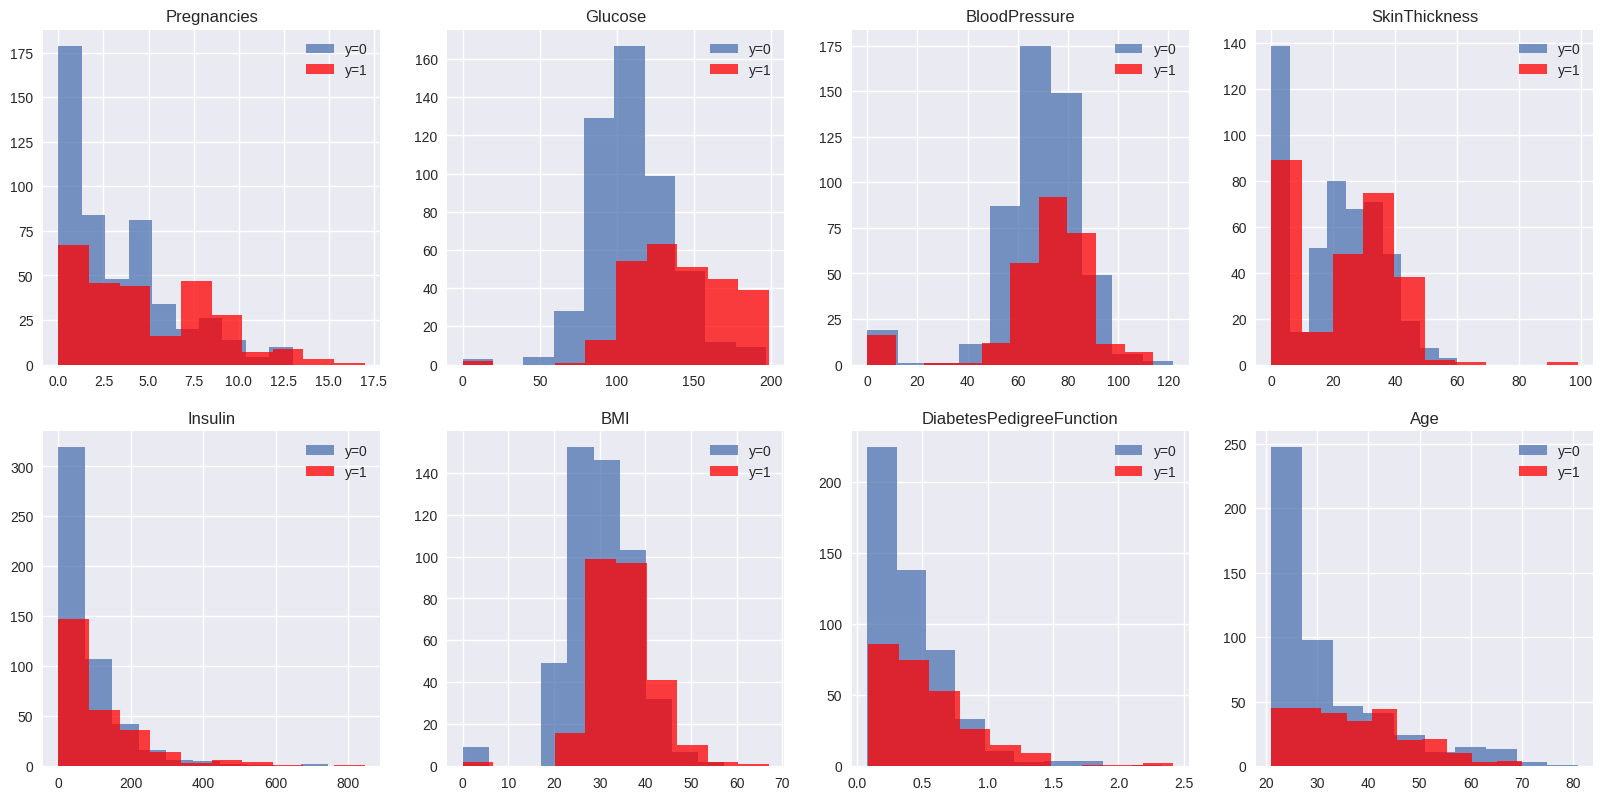

In [15]:
# ... código aquí
data = pd.read_csv('./data/diabetes.csv', sep=',', decimal='.')

# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['Outcome'] == 0
idx_1 =  data['Outcome'] == 1

for i,feature in enumerate(data.columns.drop(['Outcome'])):
    plt.subplot(4,4,i+1)   
    plt.hist(data.loc[idx_0,feature],density=0, alpha=0.75,label='y=0')
    plt.hist(data.loc[idx_1,feature],density=0, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

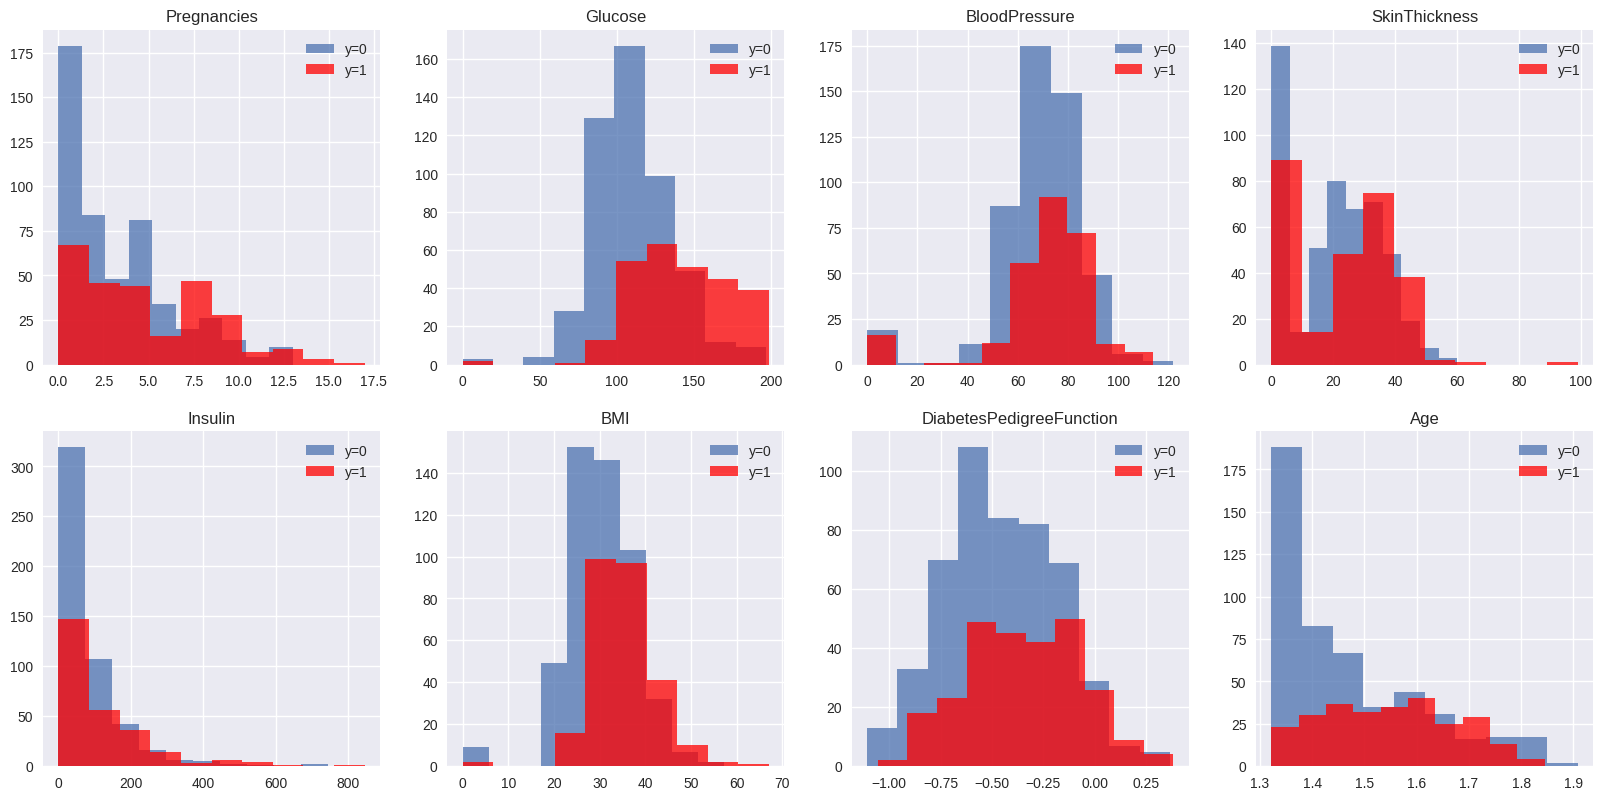

In [18]:
# ... código aquí
data = pd.read_csv('./data/diabetes.csv', sep=',', decimal='.')

features_to_transform = ['Age','DiabetesPedigreeFunction']

for feature in features_to_transform:
    data[feature] = data[feature].apply(lambda x: np.log10(x))

# Pintamos histogramas para cada clase
plt.figure(figsize=(20,20))

idx_0 =  data['Outcome'] == 0
idx_1 =  data['Outcome'] == 1

for i,feature in enumerate(data.columns.drop(['Outcome'])):
    plt.subplot(4,4,i+1)   
    plt.hist(data.loc[idx_0,feature],density=0, alpha=0.75,label='y=0')
    plt.hist(data.loc[idx_1,feature],density=0, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

Construyamos nuestro conjunto de test:

In [19]:
from sklearn.model_selection import train_test_split

# preparamos los datos
features = data.columns.drop(['Outcome'])
X = data[features].values
y = data['Outcome'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify=y)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

Datos train:  (614, 8)
Datos test:   (154, 8)


<div class = "alert alert-success">
EJERCICIO 6.3: ¿Qué diferencias hay si estratificamos? Calcula los porcentajes de la variable objetivo en ambos casos.
</div>

In [23]:
1-0.3489583333333333

0.6510416666666667

In [44]:
# ... código aquí
print('Distribución general: 34.9% 1, 65.1% 0')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
print(
    '******************'
    '\nSin estratificación'
    f'\nPorcentaje de 1 en train: {((np.unique(y_train, return_counts=True)[1][1])/len(y_train))*100:.2f}%'
    f'\nPorcentaje de 1 en test:  {((np.unique(y_test, return_counts=True)[1][1])/len(y_test))*100:.2f}%'
    '\n******************'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=0)
print(
    '******************'
    '\nCon estratificación'
    f'\nPorcentaje de 1 en train: {((np.unique(y_train, return_counts=True)[1][1])/len(y_train))*100:.2f}%'
    f'\nPorcentaje de 1 en test:  {((np.unique(y_test, return_counts=True)[1][1])/len(y_test))*100:.2f}%'
    '\n******************'
)

Distribución general: 34.9% 1, 65.1% 0
******************
Sin estratificación
Porcentaje de 1 en train: 36.13%
Porcentaje de 1 en test:  32.03%
******************
******************
Con estratificación
Porcentaje de 1 en train: 34.82%
Porcentaje de 1 en test:  35.06%
******************


### Decision trees

Probemos primero con un árbol de decisión sencillo

<div class = "alert alert-success">
EJERCICIO 6.4: Entrena un árbol de decisión sencillo extrayendo el valor óptimo de `max_depth` entre 1 y 10, y muestra las prestaciones para el conjunto de test.
</div>

Fitting 10 folds for each of 9 candidates, totalling 90 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=2; total time=   0.0s
[CV] END .......................................

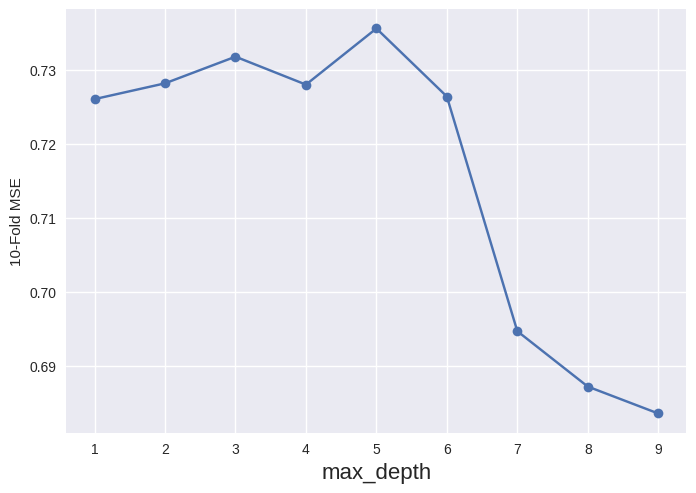

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# ... código aquí
maxDepth = range(1,10)
param_grid = {'max_depth': maxDepth}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv = 10, verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [37]:
len(y_test)

231

In [46]:
maxDepthOptimo = grid.best_params_['max_depth'] 
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ", treeModel.score(X_train, y_train))
print("Test: ", treeModel.score(X_test, y_test))

Train:  0.845437616387337
Test:  0.7316017316017316


Vamos a pintar el árbol:

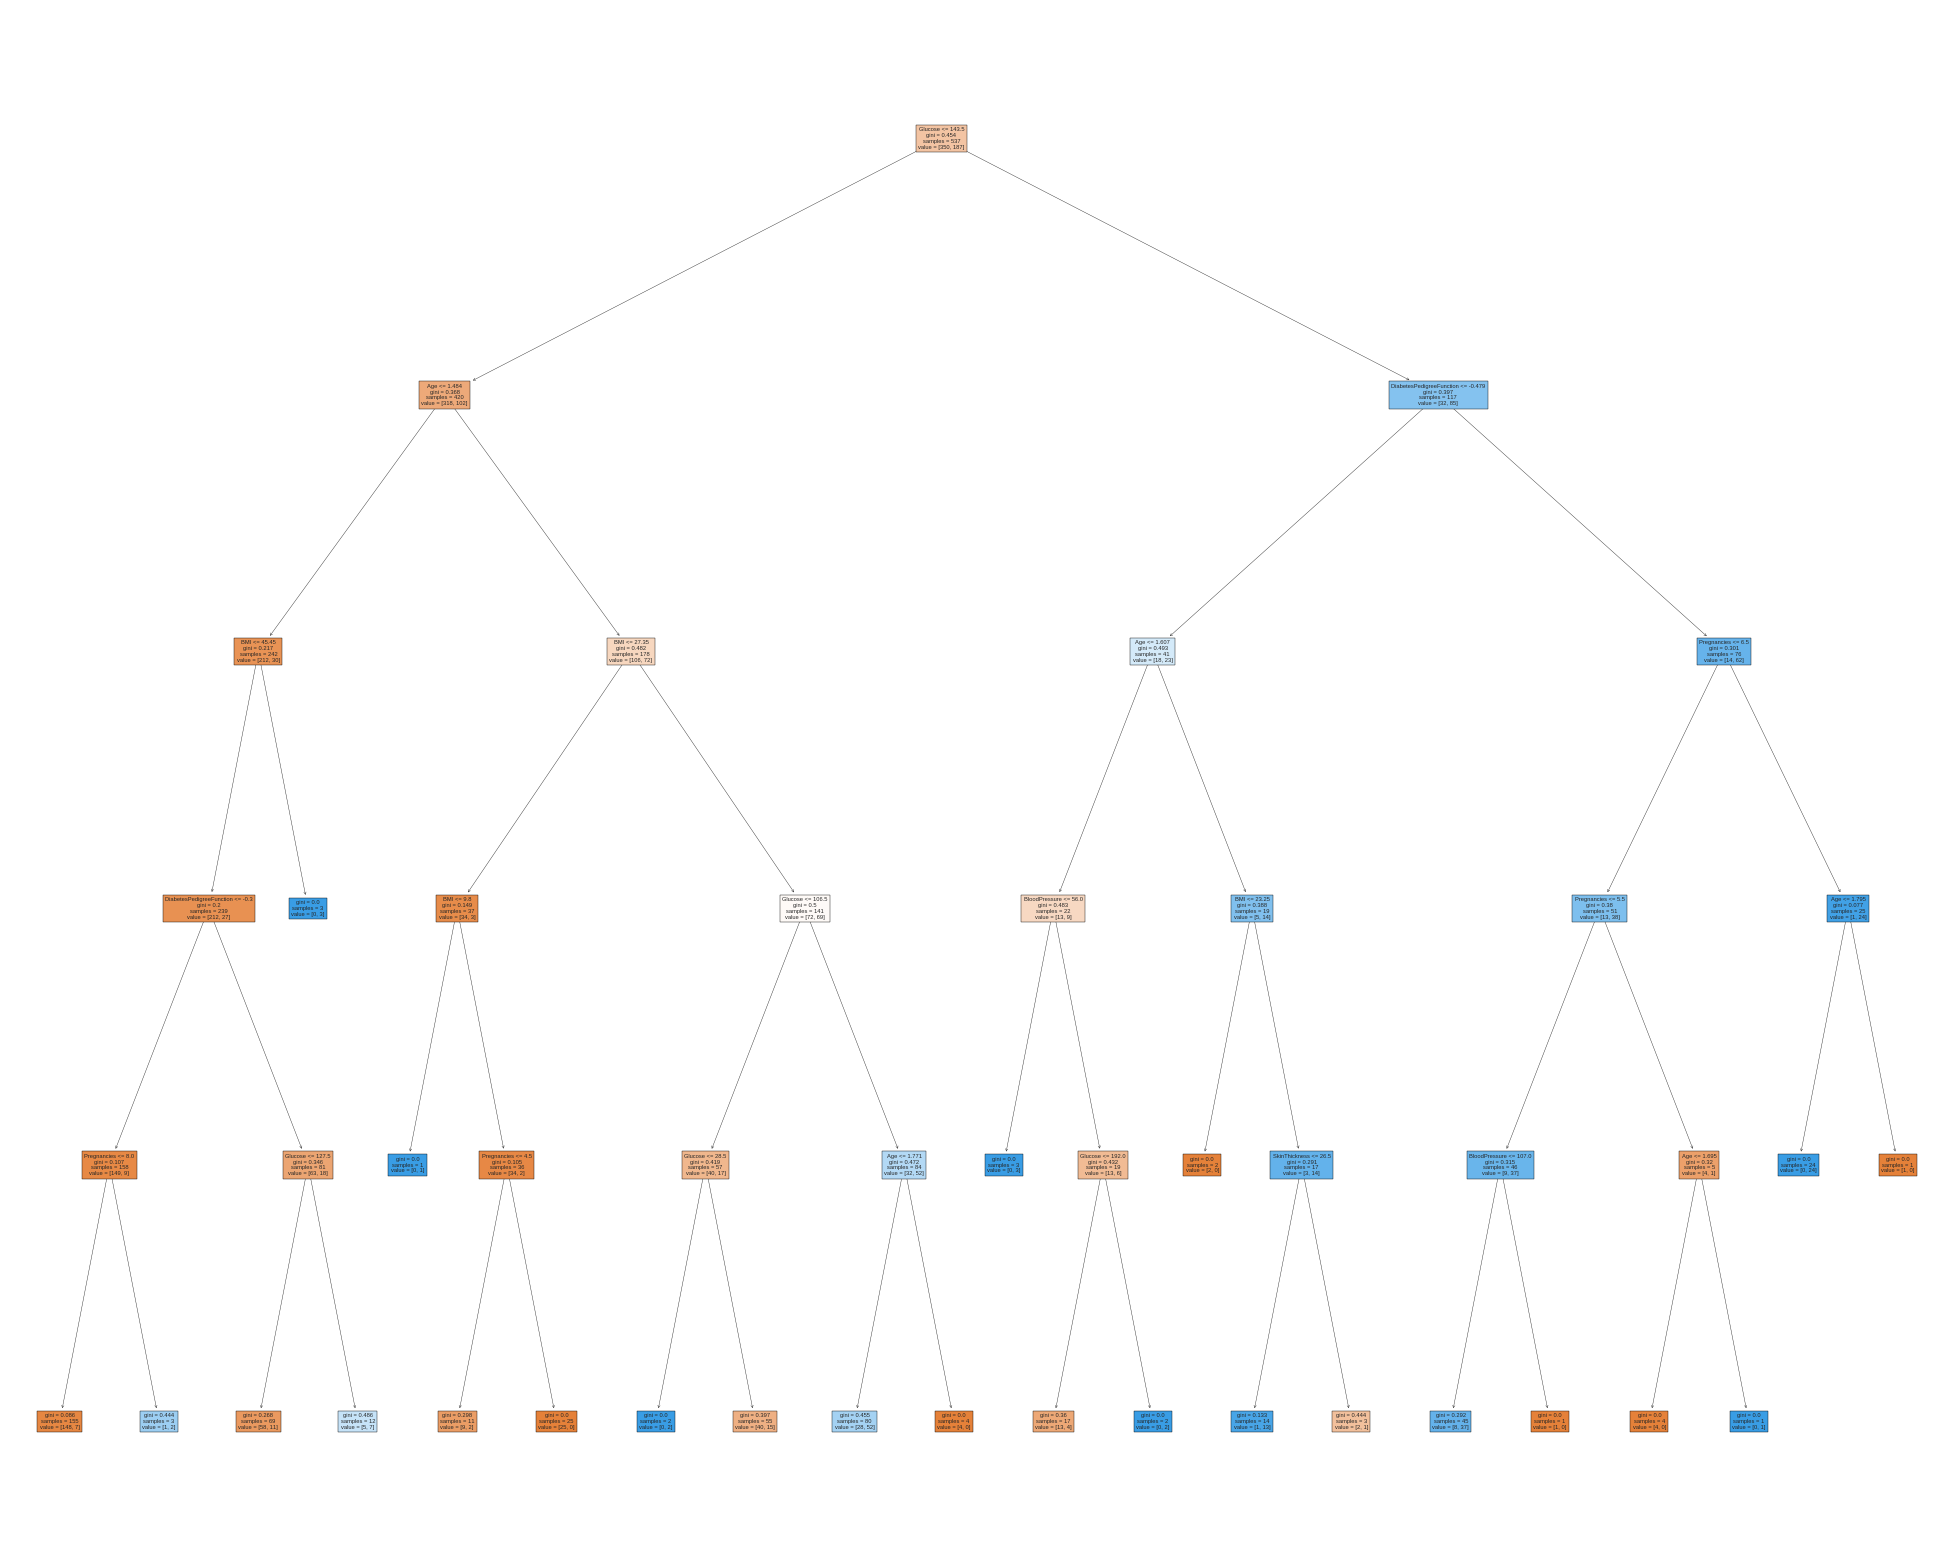

In [28]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(treeModel, feature_names=features, filled=True)

Parece un problema complicado de clasificar. Si queremos mejorar prestaciones tendremos que acudir a un modelo más complejo.

### Boosted Trees

El entrenamiento del algoritmo de boosting requiere fijar tres parámetros libres:

- Número de iteraciones
- Tasa de aprendizaje ($\alpha$)
- Complejidad del árbol: *max_depth*

Se podría hacer una búsqueda sobre los tres parámetros conjuntamente mediante GridSearchCV, pero es muy costoso computacionalmente, con lo que es más sencillo aplicar una optimización secuencial: se prueban distintos valores de los parámetros libres, se fijan los óptimos y se busca sobre el resto.

In [47]:
from sklearn.ensemble import GradientBoostingClassifier

Niterations = [25,50,75,100,125,150,175,200,300]
learningRate = [0.5,0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=3), param_grid=param_grid, cv = 3, verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END .................learning_rate=0.5, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=50; total time=   0.1s
[CV] END .................learning_rate=0.5, n_estimators=75; total time=   0.2s
[CV] END .................learning_rate=0.5, n_estimators=75; total time=   0.2s
[CV] END .................learning_rate=0.5, n_estimators=75; total time=   0.2s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=   0.2s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=   0.2s
[CV] END ................learning_rate=0.5, n_e

Representemos el error que estamos cometiendo para los distintos valores de los parámetros libres

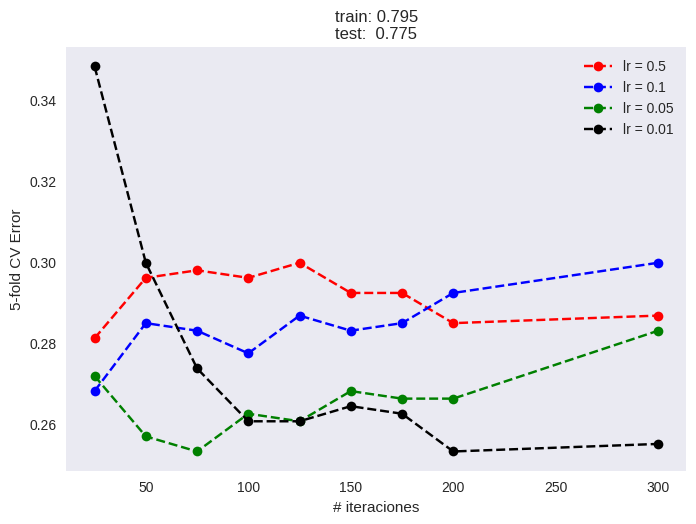

In [48]:
# calculamos métricas globales
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingClassifier(random_state=0, max_depth=2,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Las prestaciones no son mucho mejores que con respecto a un árbol sencillo. Como el coste de entrenamiento de este conjunto no es muy grande, replicaremos el análisis anterior aumentando el valor de la complejidad.

In [49]:
Niterations = [100,125,150,175,200,300, 500, 1000]
learningRate = [0.05,0.01, 0.001]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=3), param_grid=param_grid, cv = 5, verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.762
best parameters: {'learning_rate': 0.01, 'n_estimators': 500}


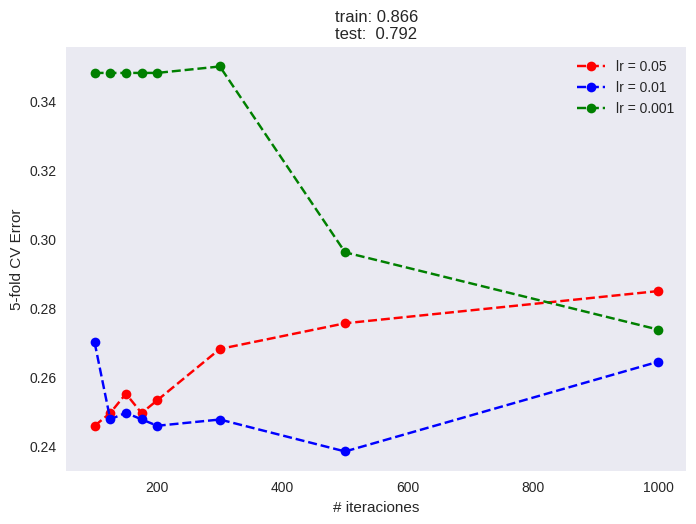

In [50]:
# calculamos métricas globales
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingClassifier(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Vemos que al aumentar la complejidad, necesitamos una tasa de aprendizaje más pequeña. En general, cuanto más complejo es el problema, menor es la tasa de aprendizaje y mayor el número de iteraciones que necesita el algoritmo. Parece que podemos ir un poco más allá, disminuyamos un poco más la tasa de aprendizaje

In [51]:
Niterations = [100,500, 1000, 1500, 2000]
learningRate = [0.05,0.01,0.001,0.0001]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=3), param_grid=param_grid, cv = 3, verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.2s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.3s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   0.2s
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   1.1s
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   1.1s
[CV] END ...............learning_rate=0.05, n_estimators=500; total time=   1.1s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   2.2s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   2.2s
[CV] END ..............learning_rate=0.05, n_estimators=1000; total time=   2.3s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=   3.5s
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time=   3.3s
[CV] END ..............learning_rate=0.05, n_est

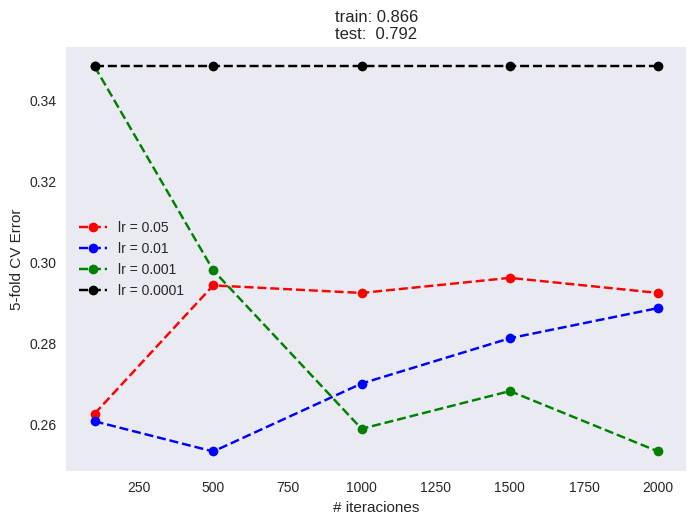

In [52]:
# calculamos métricas globales
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingClassifier(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Hemos visto un ejemplo de representación de barrido con GridSearch sobre dos parámetros. Cuidado con hacer barridos sobre muchos parámetros, porque luego no podremos visualizar! Aquí tenéis [un ejemplo sobre dos dimensiones](https://stackoverflow.com/a/43645640) y aquí uno [sobre tres](https://stackoverflow.com/a/55766938/4346986).

Podemos representar también la importancia de las variables:

<div class = "alert alert-success">
EJERCICIO 6.5: Representa la importancia de las variables.
</div>

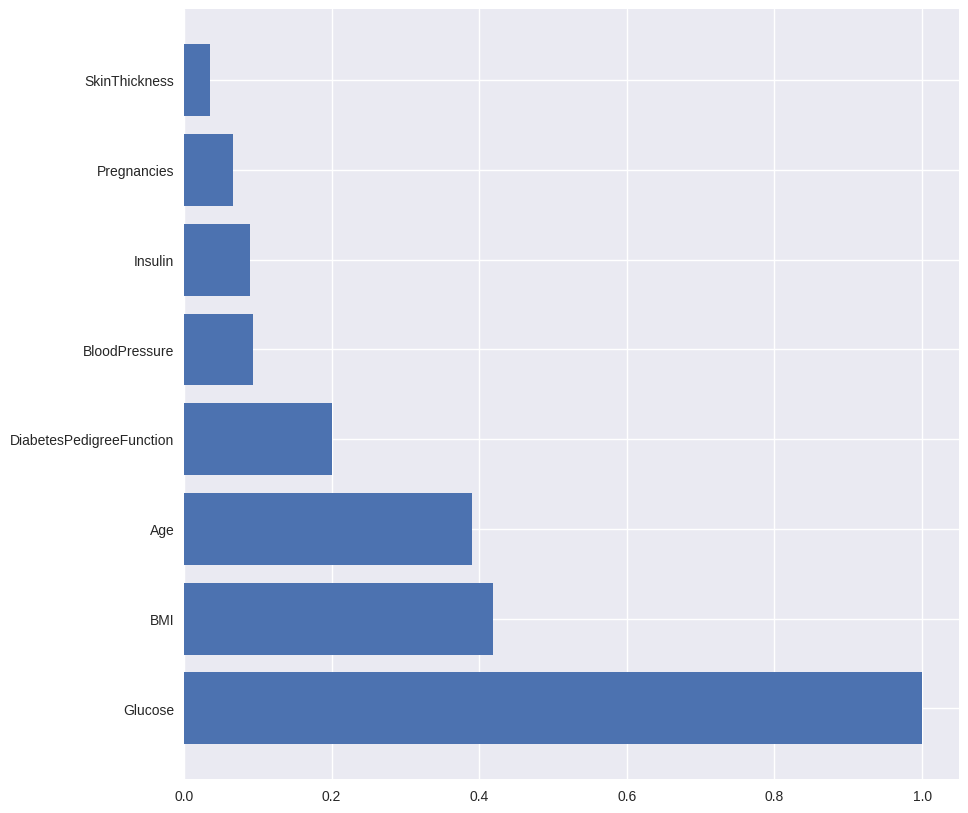

In [53]:
# ... código aquí
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

# 2. Un problema de regresión

Volvemos a nuestro conjunto de datos ya conocido:

In [54]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = 2017 - house_data['yr_built']
house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['lat_plus_long']    = house_data['lat']*house_data['long']

# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (16209, 23)
Datos test:  (5404, 23)


Dado que el número de muestras del problema es mayor, y para no extender el entrenamiento, escogeremos de forma muy secuencial los parámetros libres.

AVISO: Este proceso va a tardar un rato ...

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [1500,2000]  # barridos super pequeños: habría que aumentarlos
learningRate = [0.1,0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 3, verbose=2)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time= 1.8min
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time= 1.7min
[CV] END ...............learning_rate=0.1, n_estimators=1500; total time= 1.8min
[CV] END ...............learning_rate=0.1, n_estimators=2000; total time= 1.9min
[CV] END ...............learning_rate=0.1, n_estimators=2000; total time= 2.2min
[CV] END ...............learning_rate=0.1, n_estimators=2000; total time= 1.9min
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time= 1.4min
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time= 1.4min
[CV] END ..............learning_rate=0.05, n_estimators=1500; total time= 1.5min
[CV] END ..............learning_rate=0.05, n_estimators=2000; total time= 2.1min
[CV] END ..............learning_rate=0.05, n_estimators=2000; total time= 2.1min
[CV] END ..............learning_rate=0.05, n_esti

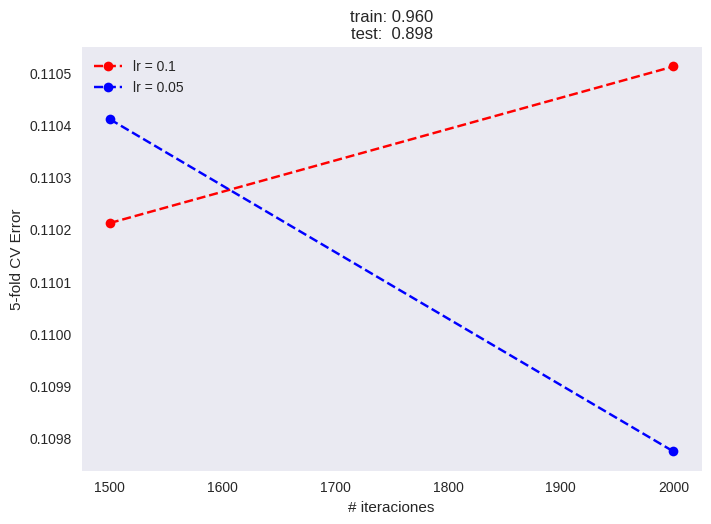

In [56]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

In [57]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
baggingModel = GradientBoostingRegressor(max_depth=3, n_estimators=neOptimo, learning_rate=lrOptimo).fit(X_train,y_train)

print("Train: ",baggingModel.score(X_train,y_train))
print("Test: ",baggingModel.score(X_test,y_test))

Train:  0.9603343223772384
Test:  0.9006646994909416


### Importancia de las variables

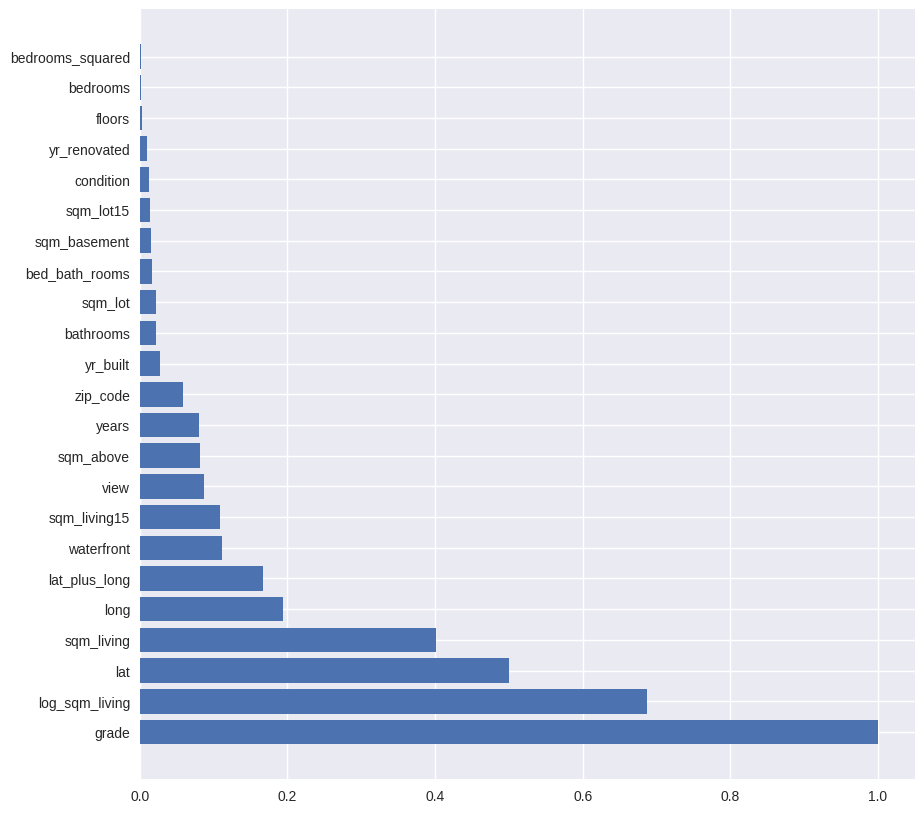

In [58]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

### What's next?

Así que, ¿qué más podríamos hacer? aumentar *max_depth*, pero seguramente incurramos en overfitting. Aquí radica el arte del *machine learning*:

1. Conoce el problema (negocio), para generar nuevas *features* de interés
2. Trata de buscar más ejemplos para utilizar técnicas de aprendizaje profundo